# Chapter 9: Classification and Regression Trees (CART)


> (c) 2019-2020 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.
>
> Date: 2020-03-08
>
> Python Version: 3.8.2
> Jupyter Notebook Version: 5.6.1
>
> Packages:
>   - dmba: 0.0.12
>   - matplotlib: 3.2.0
>   - numpy: 1.18.1
>   - pandas: 1.0.1
>   - scikit-learn: 0.22.2
>
> The assistance from Mr. Kuber Deokar and Ms. Anuja Kulkarni in preparing these solutions is gratefully acknowledged.


In [3]:
# Import required packages for this chapter
from pathlib import Path
import warnings

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

import matplotlib.pylab as plt

from dmba import plotDecisionTree, gainsChart, liftChart
from dmba import classificationSummary, regressionSummary

%matplotlib inline

# Problem 9.2 Predicting Delayed Flights. 

The file _FlightDelays.csv_ contains information on all commercial flights departing the Washington, DC area and arriving at New York during January 2004. For each flight, there is information on the departure and arrival airports, the distance of the route, the scheduled time and date of the flight, and so on. The variable that we are trying to predict is whether or not a flight is delayed. A delay is defined as an arrival that is at least 15 minutes later than scheduled.

__Data Preprocessing.__ Transform variable day of week (DAY_WEEK) info a categorical variable. Bin the scheduled departure time into eight bins. Use these and all other columns as predictors (excluding DAY_OF_MONTH). Partition the data into training (60%) and validation (40%) sets.

## Data Preprocessing - <u>All preprocessing has been given</u>

In [41]:
# Load the data
delays_df = pd.read_csv('Ch-09-FlightDelays.csv')
delays_df.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,1455,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime
2,1245,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime
3,1715,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime
4,1039,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime


In [42]:
# convert variable DAY_WEEK to categorical data type
delays_df['DAY_WEEK'].astype('category')

0       4
1       4
2       4
3       4
4       4
       ..
2196    6
2197    6
2198    6
2199    6
2200    6
Name: DAY_WEEK, Length: 2201, dtype: category
Categories (7, int64): [1, 2, 3, 4, 5, 6, 7]

In [43]:
# bin CRS_DEP_TIME variable into 8 bins
delays_df['binned_CRS_DEP_TIME'] = pd.cut(delays_df.CRS_DEP_TIME, 8, labels=False)
delays_df['binned_CRS_DEP_TIME'].astype('category')

0       4
1       5
2       3
3       5
4       2
       ..
2196    0
2197    5
2198    5
2199    3
2200    5
Name: binned_CRS_DEP_TIME, Length: 2201, dtype: category
Categories (8, int64): [0, 1, 2, 3, 4, 5, 6, 7]

In [44]:
# remove DAY_OF_MONTH variable
predictors_df = delays_df
columns = list(delays_df.columns)
columns.remove('DAY_OF_MONTH')
predictors_df = predictors_df[columns]

In [45]:
# select only those variables which can be used for predicting the outcome.
# create a new dataframe with predictors
columns = list(predictors_df.columns)
columns

columns.remove('CRS_DEP_TIME')
columns.remove('DEP_TIME')
columns.remove('FL_DATE')
columns.remove('FL_NUM')
columns.remove('TAIL_NUM')
columns.remove('Flight Status')
predictors_df = predictors_df[columns]
predictors_df.columns

predictors_df.head()

,CARRIER,DEST,DISTANCE,ORIGIN,Weather,DAY_WEEK,binned_CRS_DEP_TIME
0,OH,JFK,184,BWI,0,4,4
1,DH,JFK,213,DCA,0,4,5
2,DH,LGA,229,IAD,0,4,3
3,DH,LGA,229,IAD,0,4,5
4,DH,LGA,229,IAD,0,4,2


In [46]:
# create dummies for categorical variables
predictors_df = pd.get_dummies(predictors_df, prefix_sep='_')
predictors_df.columns

Index(['DISTANCE', 'Weather', 'DAY_WEEK', 'binned_CRS_DEP_TIME', 'CARRIER_CO',
       'CARRIER_DH', 'CARRIER_DL', 'CARRIER_MQ', 'CARRIER_OH', 'CARRIER_RU',
       'CARRIER_UA', 'CARRIER_US', 'DEST_EWR', 'DEST_JFK', 'DEST_LGA',
       'ORIGIN_BWI', 'ORIGIN_DCA', 'ORIGIN_IAD'],
      dtype='object')

In [47]:
# partition the data into training (60%) and validation (40%) sets. set random_state=1 for the reproducibility of results
X = predictors_df
y = delays_df['Flight Status']

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)
train_X.head()

,DISTANCE,Weather,DAY_WEEK,binned_CRS_DEP_TIME,CARRIER_CO,CARRIER_DH,CARRIER_DL,CARRIER_MQ,CARRIER_OH,CARRIER_RU,CARRIER_UA,CARRIER_US,DEST_EWR,DEST_JFK,DEST_LGA,ORIGIN_BWI,ORIGIN_DCA,ORIGIN_IAD
1215,229,0,7,7,0,1,0,0,0,0,0,0,0,0,1,0,0,1
1476,214,0,3,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0
1897,214,0,2,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0
83,214,0,5,3,0,0,0,0,0,0,0,1,0,0,1,0,1,0
1172,213,0,6,4,0,0,1,0,0,0,0,0,0,1,0,0,1,0


# Begin here ...
__9.2.a.__ Fit a classification tree to the flight delay variable using all the relevant predictors. Do not include DEP_TIME (actual departure time) in the model because it is unknown at the time of prediction (unless we are generating our predictions of delays after the plane takes off, which is unlikely). Use a tree with maximum depth 8 and minimum impurity decrease = 0.01. Express the resulting tree as a set of rules.
### Code missing in next cell

In [51]:
#Define/Create decision tree for CLASSIFICATION with a Depth of 1
### MISSING ONE LINE OF CODE


# fit the tree model 
### MISSING ONE LINE OF CODE


print('Tree has {} nodes'.format(smallClassTree.tree_.node_count))

Tree has 3 nodes


### Code missing in next cell

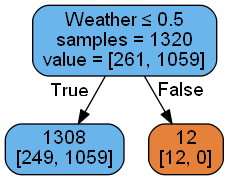

In [52]:
#Print Decision tree (skip this cell or use one of the alternate visual trees shown in the class videos and examples
#  if you cannot get graphviz installed
### MISSING ONE LINE OF CODE


The limited tree has only one splitting variable: Weather

If (Weather <= 0.5) then classify as Ontime.

__9.2.b.__ If you needed to fly between DCA and EWR on a Monday at 7:00 AM, would you be able to use this tree? What other information would you need? Is it available in practice? What information is redundant?

__Answer:__ 

????

__9.2.c.__ Fit the same tree as in (a), this time excluding the Weather predictor. Display both the resulting (small) tree and the full-grown tree. You will find that the small tree contains a single terminal node.
### Preprocessing - Given

In [50]:
# remove variable Weather from the analysis
predictors1_df = predictors_df
columns = list(predictors_df.columns)
columns
columns.remove('Weather')
predictors1_df = predictors1_df[columns]
predictors1_df.columns

Index(['DISTANCE', 'DAY_WEEK', 'binned_CRS_DEP_TIME', 'CARRIER_CO',
       'CARRIER_DH', 'CARRIER_DL', 'CARRIER_MQ', 'CARRIER_OH', 'CARRIER_RU',
       'CARRIER_UA', 'CARRIER_US', 'DEST_EWR', 'DEST_JFK', 'DEST_LGA',
       'ORIGIN_BWI', 'ORIGIN_DCA', 'ORIGIN_IAD'],
      dtype='object')

In [53]:
#Define X and Y variables
X1 = predictors1_df
y1 = delays_df['Flight Status']

#Split Data
train_X1, valid_X1, train_y1, valid_y1 = train_test_split(X1, y1, test_size=0.4, random_state=1)

### Code missing in next cell

In [55]:
# full-grown tree

#Create/Define tree
### MISSING ONE LINE OF CODE


#Fit/run Tree on training data
### MISSING ONE LINE OF CODE


print('Tree has {} nodes'.format(fullClassTree.tree_.node_count))

Tree has 593 nodes


### Code missing in next cell

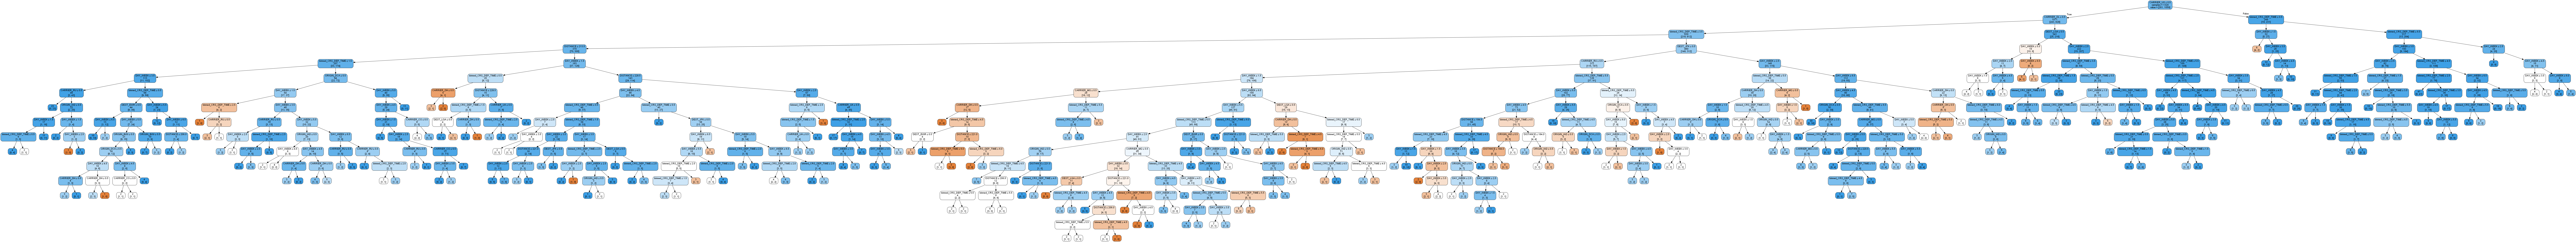

In [56]:
#Print Decision tree (skip this cell or use one of the alternate visual trees shown in the class videos and examples
#  if you cannot get graphviz installed
### MISSING ONE LINE OF CODE


### Code missing in next cell

Tree has 1 nodes


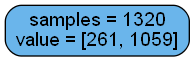

In [18]:
# small tree

#Create/Define a classification tree with a depth of 1
### MISSING ONE LINE OF CODE


#Fit/run Tree on training data
### MISSING ONE LINE OF CODE


print('Tree has {} nodes'.format(ClassTree.tree_.node_count))

### Code missing in next cell

In [ ]:
#Print Decision tree (skip this cell or use one of the alternate visual trees shown in the class videos and examples
#  if you cannot get graphviz installed
### MISSING ONE LINE OF CODE


__9.2.c.i.__ How is the small tree used for classification? (What is the rule for classifying or how woul you describe it?)

__Answer:__ 

?????????????

__9.2.c.iii.__ Examine the full-grown tree. What are the top three predictors according to this tree?

__Answer:__

??????

__9.2.c.iv.__ Why did the small tree stop at a single node?

__Answer:__

???????